# Lab 5: Human in the Loop


## Setup and Initialization

We start by setting up our environment and importing necessary modules. A crucial component is the checkpointer:

```python
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
```

The checkpointer functions similarly to a distributed version control system like Git, but for AI states. It allows us to create "commits" of our AI's state at different points in its decision-making process, and "branch" or "revert" as needed.

Be aware that excessive use of check-pointing can lead to significant memory usage, especially with large state objects. Implement a strategy to manage or expire old checkpoints in long-running applications. Think of usage of Time-To-Live for those checkpoints to be implemented in your database, if you no longer have a need for those checkpoints.
We will be using SQLite as our database of choice for our checkpoints, but you might want to switch to either Redis or Postgres for your production applications.


In [1]:
from dotenv import load_dotenv
import os
from pprint import pprint

import sys
import json, re
import pprint
import boto3
from botocore.client import Config
import warnings

warnings.filterwarnings("ignore")
import logging

# import local modules
dir_current = os.path.abspath("")
dir_parent = os.path.dirname(dir_current)
if dir_parent not in sys.path:
    sys.path.append(dir_parent)
from utils import utils

bedrock_config = Config(
    connect_timeout=120, read_timeout=120, retries={"max_attempts": 0}
)

# Set basic configs
logger = utils.set_logger()
pp = utils.set_pretty_printer()

# Load environment variables from .env file or Secret Manager
_ = load_dotenv("../.env")
aws_region = os.getenv("AWS_REGION")
tavily_ai_api_key = utils.get_tavily_api("TAVILY_API_KEY", aws_region)


# Create a bedrock runtime client
bedrock_rt = boto3.client(
    "bedrock-runtime", region_name=aws_region, config=bedrock_config
)

# Create a bedrock client to check available models
bedrock = boto3.client("bedrock", region_name=aws_region, config=bedrock_config)


[2025-10-07 00:59:01,548] p7714 {utils.py:46} INFO - TAVILY_API_KEY variable correctly retrieved from the .env file.


In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_aws import ChatBedrockConverse
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

Next, we set up our agent state with a custom message handling function:


In [3]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""


def reduce_messages(
    left: list[AnyMessage], right: list[AnyMessage]
) -> list[AnyMessage]:
    # assign ids to messages that don't have th
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged


class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

This function acts like a smart message broker in a microservices architecture. It ensures that our conversation history remains consistent and up-to-date, crucial for maintaining context in long-running AI interactions.

## Tool and Agent Setup

We integrate the Tavily search tool:


In [4]:
tool = TavilySearchResults(max_results=2)

## Human Intervention in the Agent Class

The `Agent` class implements several key features that enable human intervention in the AI's decision-making process:

1. **Interrupt Before Action**:

   ```python
   self.graph = graph.compile(
       checkpointer=checkpointer, interrupt_before=["action"]
   )
   ```

   This line sets up an interrupt before the "action" node. It allows human oversight before any action is taken, providing an opportunity for review or modification.
   You can add interrupts before any node you wish for as we will see in the next lab.

2. **State Examination**:
   The `exists_action` method prints the current state:

   ```python
   def exists_action(self, state: AgentState):
       print(state)
       # ...
   ```

   This allows humans to inspect the AI's current state, including its reasoning and intended actions.

3. **Action Visibility**:
   In the `take_action` method, each tool call is printed:

   ```python
   print(f"Calling: {t}")
   ```

   This provides visibility into what actions the AI is about to take, allowing for potential human intervention.

4. **Checkpointing**:
   The `checkpointer` parameter in the constructor allows for saving and loading states. This enables "time travel" functionality, where humans can revisit and potentially modify previous decision points.

5. **Modifiable State**:
   The `AgentState` is a mutable structure. While not shown in this class directly, it allows for state modification, enabling humans to alter the AI's context or decisions.

These features collectively create a framework for human-in-the-loop AI, where human operators can monitor, intervene, and guide the AI's decision-making process at critical junctures.


In [5]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_bedrock)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", self.exists_action, {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer, interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_bedrock(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t["name"]].invoke(t["args"])
            results.append(
                ToolMessage(tool_call_id=t["id"], name=t["name"], content=str(result))
            )
        print("Back to the model!")
        return {"messages": results}

The `interrupt_before=["action"]` parameter implements a critical control point in our AI pipeline.

It's analogous to implementing approval gates in a CI/CD pipeline, ensuring that no critical action is taken without necessary checks.

To deepen your understanding of AI safety and control mechanisms, explore the paper ["Concrete Problems in AI Safety"](https://arxiv.org/abs/1606.06565) from researchers at Google, Stanford, and Berkeley from 2016.

## Initializing and Running the Agent

We initialize our agent with Claude on Amazon Bedrock:


In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatBedrockConverse(
    client=bedrock_rt,
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
)
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

/home/workshop/langgraph-agents-with-amazon-bedrock/.venv/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The class `ChatBedrockConverse` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [7]:
messages = [HumanMessage(content="Whats the weather in Berlin?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in Berlin?', id='03c7feb7-440a-429d-ad8b-635a9a512275'), AIMessage(content=[{'type': 'tool_use', 'name': 'tavily_search_results_json', 'input': {'query': 'weather in berlin'}, 'id': 'tooluse_qUoGUCZ5SLO-CWexxCi0NQ'}], response_metadata={'ResponseMetadata': {'RequestId': 'e436b175-db70-4641-b600-d099a86865bd', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 06 Oct 2025 17:59:05 GMT', 'content-type': 'application/json', 'content-length': '325', 'connection': 'keep-alive', 'x-amzn-requestid': 'e436b175-db70-4641-b600-d099a86865bd'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 609}}, id='run-62577dd0-7dce-4246-8068-6762004e07c8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in berlin'}, 'id': 'tooluse_qUoGUCZ5SLO-CWexxCi0NQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}
{'messages': [AIMessage(content=[{'type':

In [8]:
thread

{'configurable': {'thread_id': '1'}}

## Examining and Modifying State

The ability to examine and modify the agent's state is a powerful feature:


In [9]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in Berlin?', id='03c7feb7-440a-429d-ad8b-635a9a512275'), AIMessage(content=[{'id': 'tooluse_qUoGUCZ5SLO-CWexxCi0NQ', 'input': {'query': 'weather in berlin'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '325', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:05 GMT', 'x-amzn-requestid': 'e436b175-db70-4641-b600-d099a86865bd'}, 'HTTPStatusCode': 200, 'RequestId': 'e436b175-db70-4641-b600-d099a86865bd', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 609}, 'stopReason': 'tool_use'}, id='run-62577dd0-7dce-4246-8068-6762004e07c8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in berlin'}, 'id': 'tooluse_qUoGUCZ5SLO-CWexxCi0NQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}, next=('action',), c

This capability is similar to having a live debugger in a production environment, allowing you to inspect and modify the state of a running process.


In [10]:
abot.graph.get_state(thread).next

('action',)

As you can see, the next node to be executed is the `('action',)` node.

Remember, we compiled our graph with the interrupt set before the `action` node.

```python
        self.graph = graph.compile(
            checkpointer=checkpointer, interrupt_before=["action"]
        )
```


### ...continue after interrupt

Now that stopped before the action (calling tavily-ai), we can continue. Lets see how that works.


In [11]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in berlin'}, 'id': 'tooluse_qUoGUCZ5SLO-CWexxCi0NQ', 'type': 'tool_call'}


Back to the model!
{'messages': [ToolMessage(content="[{'url': 'https://en.climate-data.org/europe/germany/berlin/berlin-2138/t/october-10/', 'content': '| Max. Temperature °C (°F) | 2.8 °C (37) °F | 4.4 °C (40) °F | 8.4 °C (47.1) °F | 14.4 °C (57.9) °F | 18.9 °C (66.1) °F | 22.1 °C (71.8) °F | 24 °C (75.3) °F | 23.9 °C (75) °F | 19.6 °C (67.2) °F | 13.8 °C (56.8) °F | 8 °C (46.4) °F | 4.2 °C (39.6) °F |\\n| Precipitation / Rainfall mm (in) | 56 (2) | 41 (1) | 53 (2) | 42 (1) | 60 (2) | 67 (2) | 81 (3) | 62 (2) | 56 (2) | 49 (1) | 48 (1) | 54 (2) |\\n| Humidity(%) | 84% | 81% | 77% | 68% | 66% | 64% | 65% | 65% | 71% | 80% | 86% | 84% | [...] | Rainy days (d) | 9 | 7 | 9 | 8 | 8 | 8 | 9 | 8 | 7 | 7 | 8 | 9 |\\n| avg. Sun hours (hours) | 2.7 | 3.9 | 5.4 | 8.7 | 10.2 | 11.0 | 10.9 | 10.2 | 7.4 | 5.0 | 3.5 | 2.6 | [...] | Min. Temperature °C (°F) | -1.9 °C (28.6) °F | -1.4 °C (29.5) °F | 0.6 °C (33.2) °F | 4.6 °C (40.3) °F | 9.4 °C (48.9) °F | 12.9 °C (55.2) °F | 15.2 °C (59.4) °F | 14.9 

In [12]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in Berlin?', id='03c7feb7-440a-429d-ad8b-635a9a512275'), AIMessage(content=[{'id': 'tooluse_qUoGUCZ5SLO-CWexxCi0NQ', 'input': {'query': 'weather in berlin'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '325', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:05 GMT', 'x-amzn-requestid': 'e436b175-db70-4641-b600-d099a86865bd'}, 'HTTPStatusCode': 200, 'RequestId': 'e436b175-db70-4641-b600-d099a86865bd', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 609}, 'stopReason': 'tool_use'}, id='run-62577dd0-7dce-4246-8068-6762004e07c8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in berlin'}, 'id': 'tooluse_qUoGUCZ5SLO-CWexxCi0NQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501}), ToolMessage(content="

In [13]:
abot.graph.get_state(thread).next

()

### Adding your human input

Next, we will see how to add your approval for executing the `action` to search the web.

Depending if you are running in JupyterLab or in e.g. VS Code, the input box should pop up below the code cell, or on the top.

![input box example, asking for user input](../assets/lab5_1.png)


If you are fine with what will be searched, then please add a `y` for yes. Anything else, will abort the operation.


In [14]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread), "\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='e457b3d8-8fea-424b-9194-3e6f5ced70f3'), AIMessage(content=[{'type': 'tool_use', 'name': 'tavily_search_results_json', 'input': {'query': 'weather in LA'}, 'id': 'tooluse_8rqHww6gT7e0TCNZWwl1GA'}], response_metadata={'ResponseMetadata': {'RequestId': 'fd53583b-980c-4a57-bef8-4857c03ff7f6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 06 Oct 2025 17:59:12 GMT', 'content-type': 'application/json', 'content-length': '321', 'connection': 'keep-alive', 'x-amzn-requestid': 'fd53583b-980c-4a57-bef8-4857c03ff7f6'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 957}}, id='run-e9cf14f0-965a-4715-bf3a-feec757a9d12-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': 'tooluse_8rqHww6gT7e0TCNZWwl1GA', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}
{'messages': [AIMessage(content=[{'type': 'tool_use',

As you can see, the next node to be executed is the `('action',)` node.

Remember, we compiled our graph with the interrupt set before the `action` node.

```python
        self.graph = graph.compile(
            checkpointer=checkpointer, interrupt_before=["action"]
        )
```

---


Now one thing that can be very interesting, is to only stop and ask for human input, whenever you are calling a certain set of tools, and not all of them.

Think about how that could be achieved, before continue reading.


### Stop at only specific tool calls

1. Parsing the tool call and stopping execution only if the tool call parameter `name` (tool name) is the same as as the stopping parameter.
2. Adding all tools where you need to stop to an extra node.

In general, option 2 is a cleaner and easier to debug. If you would like to see how this is implemented in a bigger example, please head over to the [customer support agent](https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/#part-3-conditional-interrupt) from the LangGraph examples to see how sensitive tools are handled.

Here is a sneak peak of the graph:

![customer support agent graph with sensitive and safe tools](../assets/lab5_2.png)


## Modify State

Run until the interrupt and then modify the state.


In [15]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2'), AIMessage(content=[{'type': 'tool_use', 'name': 'tavily_search_results_json', 'input': {'query': 'weather in LA'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ'}], response_metadata={'ResponseMetadata': {'RequestId': '83509b13-d0c6-432f-84ad-2ca07b41f829', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 06 Oct 2025 17:59:20 GMT', 'content-type': 'application/json', 'content-length': '321', 'connection': 'keep-alive', 'x-amzn-requestid': '83509b13-d0c6-432f-84ad-2ca07b41f829'}, 'RetryAttempts': 0}, 'stopReason': 'tool_use', 'metrics': {'latencyMs': 646}}, id='run-e7e2db49-0e60-42c9-b2c7-33c09274eeb0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}
{'messages': [AIMessage(content=[{'type': 'tool_use',

In [16]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2'), AIMessage(content=[{'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'input': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '321', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:20 GMT', 'x-amzn-requestid': '83509b13-d0c6-432f-84ad-2ca07b41f829'}, 'HTTPStatusCode': 200, 'RequestId': '83509b13-d0c6-432f-84ad-2ca07b41f829', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 646}, 'stopReason': 'tool_use'}, id='run-e7e2db49-0e60-42c9-b2c7-33c09274eeb0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}, next=('action',), config={'conf

In [17]:
current_values = abot.graph.get_state(thread)

In [18]:
current_values.values["messages"][-1]

AIMessage(content=[{'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'input': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '321', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:20 GMT', 'x-amzn-requestid': '83509b13-d0c6-432f-84ad-2ca07b41f829'}, 'HTTPStatusCode': 200, 'RequestId': '83509b13-d0c6-432f-84ad-2ca07b41f829', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 646}, 'stopReason': 'tool_use'}, id='run-e7e2db49-0e60-42c9-b2c7-33c09274eeb0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})

In [19]:
current_values.values["messages"][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in LA'},
  'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ',
  'type': 'tool_call'}]

In [20]:
_id = current_values.values["messages"][-1].tool_calls[0]["id"]
current_values.values["messages"][-1].tool_calls = [
    {
        "name": "tavily_search_results_json",
        "args": {"query": "current weather in Munich"},
        "id": _id,
    }
]

In [21]:
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2'), AIMessage(content=[{'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'input': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '321', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:20 GMT', 'x-amzn-requestid': '83509b13-d0c6-432f-84ad-2ca07b41f829'}, 'HTTPStatusCode': 200, 'RequestId': '83509b13-d0c6-432f-84ad-2ca07b41f829', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 646}, 'stopReason': 'tool_use'}, id='run-e7e2db49-0e60-42c9-b2c7-33c09274eeb0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Munich'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}


{'configurable': {'thread_id': '3',
  'thread_ts': '1f0a2de2-f685-636e-8002-30c9b31af640'}}

In [22]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2'), AIMessage(content=[{'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'input': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '321', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:20 GMT', 'x-amzn-requestid': '83509b13-d0c6-432f-84ad-2ca07b41f829'}, 'HTTPStatusCode': 200, 'RequestId': '83509b13-d0c6-432f-84ad-2ca07b41f829', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 646}, 'stopReason': 'tool_use'}, id='run-e7e2db49-0e60-42c9-b2c7-33c09274eeb0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Munich'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}, next=('action',), c

In [23]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Munich'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content="[{'url': 'https://www.weather25.com/europe/germany/bavaria/munich?page=month&month=October', 'content': '| Sun | Mon | Tue | Wed | Thu | Fri | Sat |\\n ---  ---  --- \\n|  |  |  | 1 Partly cloudy 17° /7° | 2 Light rain shower 16° /8° | 3 Patchy rain possible 16° /7° | 4 Overcast 14° /6° |\\n| 5 Overcast 14° /7° | 6 Light rain 10° /7° | 7 Light drizzle 10° /8° | 8 Partly cloudy 17° /7° | 9 Patchy rain possible 15° /8° | 10 Sunny 16° /7° | 11 Mist 15° /6° |\\n| 12 Mist 16° /6° | 13 Sunny 16° /6° | 14 Mist 14° /5° | 15 Sunny 14° /3° | 16 Sunny 14° /3° | 17 Sunny 14° /3° | 18 Mist 15° /4° | [...] | 19 Sunny 14° /4° | 20 Overcast 18° /8° | 21 Light drizzle 15° /9° | 22 Mist 14° /8° | 23 Partly cloudy 15° /7° | 24 Partly cloudy 15° /8° | 25 Light drizzle 16° /8° |\\n| 26 Mist 14° /8° 

## Time Travel


In [24]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print("--")
    states.append(state)

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '3', 'thread_ts': '1f0a2de2-ebf4-6382-bfff-13a0ef49fd8b'}}, metadata={'source': 'input', 'step': -1, 'writes': {'messages': [HumanMessage(content='Whats the weather in LA?')]}}, created_at='2025-10-06T17:59:19.921084+00:00', parent_config=None)
--
StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2')]}, next=('llm',), config={'configurable': {'thread_id': '3', 'thread_ts': '1f0a2de2-ec00-6a6d-8000-2db00157585e'}}, metadata={'source': 'loop', 'step': 0, 'writes': None}, created_at='2025-10-06T17:59:19.926183+00:00', parent_config=None)
--
StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2'), AIMessage(content=[{'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'input': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], 

To fetch the same state as was filmed, the offset below is changed to `-3` from `-1`. This accounts for the initial state `__start__` and the first state that are now stored to state memory with the latest version of software.


In [25]:
to_replay = states[-3]

In [26]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2'), AIMessage(content=[{'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'input': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '321', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:20 GMT', 'x-amzn-requestid': '83509b13-d0c6-432f-84ad-2ca07b41f829'}, 'HTTPStatusCode': 200, 'RequestId': '83509b13-d0c6-432f-84ad-2ca07b41f829', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 646}, 'stopReason': 'tool_use'}, id='run-e7e2db49-0e60-42c9-b2c7-33c09274eeb0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Munich'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}, next=('action',), c

In [27]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Munich'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content="[{'url': 'https://www.weather25.com/europe/germany/bavaria/munich?page=month&month=October', 'content': 'United States England Australia Canada\\n\\n°F °C\\n\\nWeather in October 2025\\n\\n1. Home\\n2. Europe\\n3. Germany\\n4. Bavaria\\n5. Munich\\n6. October\\n\\nLocation was added to My Locations\\n\\nLocation was removed from My Locations\\n\\n# Munich weather in October 2025\\n\\nClick on a day for an hourly weather forecast\\n\\nOct 6\\n\\n8 mm\\n\\n10° / 7°Oct 7\\n\\n4 mm\\n\\n10° / 8°Oct 8\\n\\n0 mm\\n\\n17° / 7°Thursday\\n\\nOct 9\\n\\n0 mm\\n\\n15° / 8°Friday\\n\\nOct 10\\n\\n0 mm\\n\\n16° / 7°Saturday\\n\\nOct 11\\n\\n0 mm\\n\\n15° / 6°Sunday\\n\\nOct 12\\n\\n0 mm\\n\\n16° / 6°Monday\\n\\nOct 13\\n\\n0 mm [...] | Sun | Mon | Tue | Wed | Thu | Fri | Sat |\\n ---  ---  -

## Go back in time and edit


In [28]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2'), AIMessage(content=[{'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'input': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '321', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:20 GMT', 'x-amzn-requestid': '83509b13-d0c6-432f-84ad-2ca07b41f829'}, 'HTTPStatusCode': 200, 'RequestId': '83509b13-d0c6-432f-84ad-2ca07b41f829', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 646}, 'stopReason': 'tool_use'}, id='run-e7e2db49-0e60-42c9-b2c7-33c09274eeb0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Munich'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}, next=('action',), c

In [29]:
_id = to_replay.values["messages"][-1].tool_calls[0]["id"]
to_replay.values["messages"][-1].tool_calls = [
    {
        "name": "tavily_search_results_json",
        "args": {"query": "current weather in LA, accuweather"},
        "id": _id,
    }
]

In [30]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2'), AIMessage(content=[{'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'input': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '321', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:20 GMT', 'x-amzn-requestid': '83509b13-d0c6-432f-84ad-2ca07b41f829'}, 'HTTPStatusCode': 200, 'RequestId': '83509b13-d0c6-432f-84ad-2ca07b41f829', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 646}, 'stopReason': 'tool_use'}, id='run-e7e2db49-0e60-42c9-b2c7-33c09274eeb0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}


In [31]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'url\': \'https://www.accuweather.com/en/us/los-angeles/90012/weather-forecast/347625\', \'content\': "# Los Angeles, CA\\n\\nLos Angeles\\n\\nCalifornia\\n\\n## Around the Globe\\n\\nAround the Globe\\n\\n### Hurricane Tracker\\n\\n### Severe Weather\\n\\n### Radar & Maps\\n\\n### News & Features\\n\\n### Astronomy\\n\\n### Business\\n\\n### Climate\\n\\n### Health\\n\\n### Recreation\\n\\n### Sports\\n\\n### Travel\\n\\n### Warnings\\n\\n### Data Suite\\n\\n### Forensics\\n\\n### Advertising\\n\\n### Superior Accuracy™\\n\\n### Video\\n\\n### Winter Center\\n\\n## Today\\n\\n## Today\'s Weather\\n\\nMon, Oct 6\\n\\nAfter a cloudy start, sunshine returns\\nHi: 78° [...] Tonight: Clear this evening followed by areas of low clouds late\\nLo: 60°\\n\\n## Current Weathe

## Add message to a state at a given time


In [32]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2'), AIMessage(content=[{'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'input': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '321', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:20 GMT', 'x-amzn-requestid': '83509b13-d0c6-432f-84ad-2ca07b41f829'}, 'HTTPStatusCode': 200, 'RequestId': '83509b13-d0c6-432f-84ad-2ca07b41f829', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 646}, 'stopReason': 'tool_use'}, id='run-e7e2db49-0e60-42c9-b2c7-33c09274eeb0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501})]}, next=('action',), config={'conf

In [33]:
_id = to_replay.values["messages"][-1].tool_calls[0]["id"]

In [34]:
# Lets update the humidity to something that is impossible

state_update = {
    "messages": [
        ToolMessage(
            tool_call_id=_id,
            name="tavily_search_results_json",
            content="23 degree celcius, 110 percent humidity",
        )
    ]
}

In [35]:
branch_and_add = abot.graph.update_state(
    to_replay.config, state_update, as_node="action"
)

In [36]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', id='57dc4fcf-9acb-4fe4-bbec-c33e8c4322a2'), AIMessage(content=[{'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'input': {'query': 'weather in LA'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], response_metadata={'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive', 'content-length': '321', 'content-type': 'application/json', 'date': 'Mon, 06 Oct 2025 17:59:20 GMT', 'x-amzn-requestid': '83509b13-d0c6-432f-84ad-2ca07b41f829'}, 'HTTPStatusCode': 200, 'RequestId': '83509b13-d0c6-432f-84ad-2ca07b41f829', 'RetryAttempts': 0}, 'metrics': {'latencyMs': 646}, 'stopReason': 'tool_use'}, id='run-e7e2db49-0e60-42c9-b2c7-33c09274eeb0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Munich'}, 'id': 'tooluse_nHMKFbKQQ-SNAVSgs7wpaQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 60, 'total_tokens': 501}), ToolMessage(content='23 degree celcius, 11

# Extra Practice


## Build a small graph

This is a small simple graph you can tinker with if you want more insight into controlling state memory.


In [37]:
from dotenv import load_dotenv

_ = load_dotenv()

In [38]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator

Define a simple 2 node graph with the following state: -`lnode`: last node -`scratch`: a scratchpad location -`count` : a counter that is incremented each step


In [39]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

In [40]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {
        "lnode": "node_1",
        "count": 1,
    }


def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {
        "lnode": "node_2",
        "count": 1,
    }

The graph goes N1->N2->N1... but breaks after count reaches 3.


In [41]:
def should_continue(state):
    return state["count"] < 3

In [42]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges("Node2", should_continue, {True: "Node1", False: END})
builder.set_entry_point("Node1")

In [43]:
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

### Run it!

Now, set the thread and run!


In [44]:
thread = {"configurable": {"thread_id": str(1)}}
graph.invoke({"count": 0, "scratch": "hi"}, thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

### Look at current state


Get the current state. Note the `values` which are the AgentState. Note the `config` and the `thread_ts`. You will be using those to refer to snapshots below.


In [45]:
graph.get_state(thread)

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe6c-6ba0-8004-1e05eba43a0f'}}, metadata={'source': 'loop', 'step': 4, 'writes': {'Node2': {'count': 1, 'lnode': 'node_2'}}}, created_at='2025-10-06T17:59:48.701447+00:00', parent_config=None)

View all the statesnapshots in memory. You can use the displayed `count` agentstate variable to help track what you see. Notice the most recent snapshots are returned by the iterator first. Also note that there is a handy `step` variable in the metadata that counts the number of steps in the graph execution. This is a bit detailed - but you can also notice that the _parent_config_ is the _config_ of the previous node. At initial startup, additional states are inserted into memory to create a parent. This is something to check when you branch or _time travel_ below.


### Look at state history


In [46]:
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'count': 0}, next=('__start__',), config={'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe1b-6182-bfff-b206c21071d9'}}, metadata={'source': 'input', 'step': -1, 'writes': {'count': 0, 'scratch': 'hi'}}, created_at='2025-10-06T17:59:48.668004+00:00', parent_config=None) 

StateSnapshot(values={'scratch': 'hi', 'count': 0}, next=('Node1',), config={'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe22-67dd-8000-468894139ec5'}}, metadata={'source': 'loop', 'step': 0, 'writes': None}, created_at='2025-10-06T17:59:48.671035+00:00', parent_config=None) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe30-63f0-8001-6b9a26b37426'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, created_at='2025-10-06T17:59:48.676668+00:00', parent_config=None) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': '

Store just the `config` into an list. Note the sequence of counts on the right. `get_state_history` returns the most recent snapshots first.


In [47]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values["count"])

{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe1b-6182-bfff-b206c21071d9'}} 0
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe22-67dd-8000-468894139ec5'}} 0
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe30-63f0-8001-6b9a26b37426'}} 1
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe45-6cc4-8002-f04d29e35130'}} 2
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe4f-61a8-8003-0171d1351773'}} 3
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe6c-6ba0-8004-1e05eba43a0f'}} 4


Grab an early state.


In [48]:
states[-3]

{'configurable': {'thread_id': '1',
  'thread_ts': '1f0a2de3-fe45-6cc4-8002-f04d29e35130'}}

This is the state after Node1 completed for the first time. Note `next` is `Node2`and `count` is 1.


In [49]:
graph.get_state(states[-3])

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 2}, next=('Node1',), config={'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe45-6cc4-8002-f04d29e35130'}}, metadata={'source': 'loop', 'step': 2, 'writes': {'Node2': {'count': 1, 'lnode': 'node_2'}}}, created_at='2025-10-06T17:59:48.685497+00:00', parent_config=None)

### Go Back in Time

Use that state in `invoke` to go back in time. Notice it uses states[-3] as _current_state_ and continues to node2,


In [50]:
graph.invoke(None, states[-3])

node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

Notice the new states are now in state history. Notice the counts on the far right.


In [51]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values["count"])

{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe1b-6182-bfff-b206c21071d9'}} 0
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe22-67dd-8000-468894139ec5'}} 0
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe30-63f0-8001-6b9a26b37426'}} 1
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe45-6cc4-8002-f04d29e35130'}} 2
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe4f-61a8-8003-0171d1351773'}} 3
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe6c-6ba0-8004-1e05eba43a0f'}} 4
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de4-02a2-6b1c-8003-cbb4e437a382'}} 3
{'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de4-02ac-69a2-8004-f0c530cb9c3d'}} 4


You can see the details below. Lots of text, but try to find the node that start the new branch. Notice the parent _config_ is not the previous entry in the stack, but is the entry from state[-3].


In [52]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'count': 0}, next=('__start__',), config={'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe1b-6182-bfff-b206c21071d9'}}, metadata={'source': 'input', 'step': -1, 'writes': {'count': 0, 'scratch': 'hi'}}, created_at='2025-10-06T17:59:48.668004+00:00', parent_config=None) 

StateSnapshot(values={'scratch': 'hi', 'count': 0}, next=('Node1',), config={'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe22-67dd-8000-468894139ec5'}}, metadata={'source': 'loop', 'step': 0, 'writes': None}, created_at='2025-10-06T17:59:48.671035+00:00', parent_config=None) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '1', 'thread_ts': '1f0a2de3-fe30-63f0-8001-6b9a26b37426'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, created_at='2025-10-06T17:59:48.676668+00:00', parent_config=None) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': '

### Modify State

Let's start by starting a fresh thread and running to clean out history.


In [53]:
thread2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count": 0, "scratch": "hi"}, thread2)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

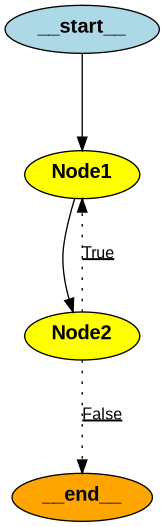

In [54]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [55]:
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values["count"])

{'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03d5-639f-bfff-72e54bef9bd3'}} 0
{'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03da-6291-8000-e626eb28faeb'}} 0
{'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03e2-6091-8001-62ca44d1ee74'}} 1
{'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03eb-62c7-8002-78ed347b2e5b'}} 2
{'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03f1-6cfb-8003-3406f85f2b70'}} 3
{'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03f7-6be2-8004-4266824b78e5'}} 4


Start by grabbing a state.


In [56]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 2}, next=('Node1',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03eb-62c7-8002-78ed347b2e5b'}}, metadata={'source': 'loop', 'step': 2, 'writes': {'Node2': {'count': 1, 'lnode': 'node_2'}}}, created_at='2025-10-06T17:59:49.277544+00:00', parent_config=None)

Now modify the values. One subtle item to note: Recall when agent state was defined, `count` used `operator.add` to indicate that values are _added_ to the current value. Here, `-3` will be added to the current count value rather than replace it.


In [57]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': -3}, next=('Node1',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03eb-62c7-8002-78ed347b2e5b'}}, metadata={'source': 'loop', 'step': 2, 'writes': {'Node2': {'count': 1, 'lnode': 'node_2'}}}, created_at='2025-10-06T17:59:49.277544+00:00', parent_config=None)

Now update the state. This creates a new entry at the _top_, or _latest_ entry in memory. This will become the current state.


In [58]:
graph.update_state(thread2, save_state.values)

{'configurable': {'thread_id': '2',
  'thread_ts': '1f0a2de4-09cc-61e8-8005-45117f088c32'}}

Current state is at the top. You can match the `thread_ts`.
Notice the `parent_config`, `thread_ts` of the new node - it is the previous node.


In [59]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  # print latest 3
        break
    print(state, "\n")

StateSnapshot(values={'count': 0}, next=('__start__',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03d5-639f-bfff-72e54bef9bd3'}}, metadata={'source': 'input', 'step': -1, 'writes': {'count': 0, 'scratch': 'hi'}}, created_at='2025-10-06T17:59:49.268545+00:00', parent_config=None) 

StateSnapshot(values={'scratch': 'hi', 'count': 0}, next=('Node1',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03da-6291-8000-e626eb28faeb'}}, metadata={'source': 'loop', 'step': 0, 'writes': None}, created_at='2025-10-06T17:59:49.270571+00:00', parent_config=None) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03e2-6091-8001-62ca44d1ee74'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, created_at='2025-10-06T17:59:49.273797+00:00', parent_config=None) 



### Try again with `as_node`

When writing using `update_state()`, you want to define to the graph logic which node should be assumed as the writer. What this does is allow th graph logic to find the node on the graph. After writing the values, the `next()` value is computed by travesing the graph using the new state. In this case, the state we have was written by `Node1`. The graph can then compute the next state as being `Node2`. Note that in some graphs, this may involve going through conditional edges! Let's try this out.


In [60]:
graph.update_state(thread2, save_state.values, as_node="Node1")

{'configurable': {'thread_id': '2',
  'thread_ts': '1f0a2de4-0a6e-6821-8006-3df90961e221'}}

In [61]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  # print latest 3
        break
    print(state, "\n")

StateSnapshot(values={'count': 0}, next=('__start__',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03d5-639f-bfff-72e54bef9bd3'}}, metadata={'source': 'input', 'step': -1, 'writes': {'count': 0, 'scratch': 'hi'}}, created_at='2025-10-06T17:59:49.268545+00:00', parent_config=None) 

StateSnapshot(values={'scratch': 'hi', 'count': 0}, next=('Node1',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03da-6291-8000-e626eb28faeb'}}, metadata={'source': 'loop', 'step': 0, 'writes': None}, created_at='2025-10-06T17:59:49.270571+00:00', parent_config=None) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03e2-6091-8001-62ca44d1ee74'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, created_at='2025-10-06T17:59:49.273797+00:00', parent_config=None) 



`invoke` will run from the current state if not given a particular `thread_ts`. This is now the entry that was just added.


In [62]:
graph.invoke(None, thread2)

node2, count:-2
node1, count:-1
node2, count:0
node1, count:1
node2, count:2


{'lnode': 'node_2', 'scratch': 'hello', 'count': 3}

Print out the state history, notice the `scratch` value change on the latest entries.


In [63]:
for state in graph.get_state_history(thread2):
    print(state, "\n")

StateSnapshot(values={'count': 0}, next=('__start__',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03d5-639f-bfff-72e54bef9bd3'}}, metadata={'source': 'input', 'step': -1, 'writes': {'count': 0, 'scratch': 'hi'}}, created_at='2025-10-06T17:59:49.268545+00:00', parent_config=None) 

StateSnapshot(values={'scratch': 'hi', 'count': 0}, next=('Node1',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03da-6291-8000-e626eb28faeb'}}, metadata={'source': 'loop', 'step': 0, 'writes': None}, created_at='2025-10-06T17:59:49.270571+00:00', parent_config=None) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '2', 'thread_ts': '1f0a2de4-03e2-6091-8001-62ca44d1ee74'}}, metadata={'source': 'loop', 'step': 1, 'writes': {'Node1': {'count': 1, 'lnode': 'node_1'}}}, created_at='2025-10-06T17:59:49.273797+00:00', parent_config=None) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': '

Continue to experiment!
